<a href="https://colab.research.google.com/github/gautamvdblt/vanderbilt-ml/blob/feature%2Fassignment-3/FIFA-WorldCup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Using Fifa World Cup Data**

Fifa world cup notebook

## Background

The FIFA World Cup is the most prestigious football tournament in the world. The championship has been awarded every four years since the start of the tournament in 1930.

In this Project, we will use https://www.kaggle.com/datasets/brenda89/fifa-world-cup-2022.


## Project Description

The FIFA World Cup involves a qualification phase, which takes place over the preceding three years, to determine which teams quality for the tournament. In the tournament, 32 teams, including the host nation, compete for the title at different stadiums in the host country.

This dataset provides a complete overview of all international soccer matches played since the 90s. On top of that, the strength of each team is provided by incorporating actual FIFA rankings as well as player strengths based on the EA Sport FIFA video game.

## Performance Metric

In this project we will try to 
· Which team has the longest winning streak. Is there any home team advantage?


## Load Libraries

First, we'll load our standard libraries for loading data, basic exploratory data analsysi (EDA), and machine learning. 

In [2]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#machine learning


In [4]:
df = pd.read_csv('data_dictionary.csv')
df.tail()



,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
25728,6/14/2022,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25729,6/14/2022,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
25730,6/14/2022,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
25731,6/14/2022,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
25732,6/14/2022,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


## EDA

First, we'll load our standard libraries for loading data, basic exploratory data analsysi (EDA), and machine learning. 

## 1) What are the 10 strongest teams

Strongest team is defined by each team is awarded a certain number of points based on wheteher the won or drawn, the importance of the match and the strength of the opposing team. The overall number of points determines the FIFA rank of the team.

In [11]:
fifa_rank = df[['date', 'home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank']]
home = fifa_rank[['date', 'home_team','home_team_fifa_rank']].rename(columns = {'home_team': 'team', 'home_team_fifa_rank' : 'rank'})
away = fifa_rank[['date', 'away_team','away_team_fifa_rank']].rename(columns = {'away_team': 'team', 'away_team_fifa_rank' : 'rank'})
fifa_rank = home.append(away)

#select for each country the latest match
fifa_rank  = fifa_rank.sort_values(['team', 'date'], ascending=[True, False])
fifa_rank['row_number'] = fifa_rank.groupby('team').cumcount()+1
fifa_rank_top = fifa_rank[fifa_rank['row_number']==1].drop('row_number',axis=1).nsmallest(10, 'rank')

fifa_rank_top

,date,team,rank
23337,9/9/2019,Belgium,1
22347,9/9/2018,France,1
24811,9/9/2021,Brazil,2
14471,9/9/2009,Spain,2
24810,9/9/2021,Argentina,6
23332,9/9/2019,Croatia,7
14448,9/9/2009,England,7
22349,9/9/2018,Denmark,9
14472,9/9/2009,USA,11
14461,9/9/2009,Greece,12


## 2) Is there any home team advantage in the world cup?

First, we'll load our standard libraries for loading data, basic exploratory data analsysi (EDA), and machine learning. 

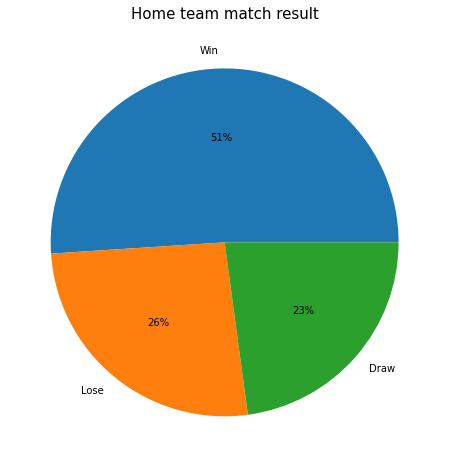

In [7]:
home_team_advantage = df[df['neutral_location']==False]['home_team_result'].value_counts(normalize=True)

#plot
fig, axes = plt.subplots(1,1,  figsize=(8,8))
ax =plt.pie(home_team_advantage  ,labels = ['Win',  'Lose', 'Draw'],  autopct='%.0f%%')
plt.title('Home team match result', fontsize = 15)
plt.show()

## 3) What team has the strongest offense.

It is often said that the most important position in soccer is the striker. Without the striker, the team would score fewer goals which reduces the chances of the team winning the match. What team has the strongest offense? 

In [14]:
#let's re-shape the data a bit
offense = df[['date', 'home_team', 'away_team', 'home_team_mean_offense_score', 'away_team_mean_offense_score']]
home = offense [['date', 'home_team','home_team_mean_offense_score']].rename(columns = {'home_team': 'team', 'home_team_mean_offense_score' : 'offense_score'})
away = offense [['date', 'away_team','away_team_mean_offense_score']].rename(columns = {'away_team': 'team', 'away_team_mean_offense_score' : 'offense_score'})
offense  = home.append(away)

In [15]:

#select for each country the latest match
offense   = offense .sort_values(['team', 'date'], ascending=[True, False])
offense ['row_number'] = offense .groupby('team').cumcount()+1
offense_top = offense [offense ['row_number']==1].drop('row_number',axis=1).nlargest(20, 'offense_score')

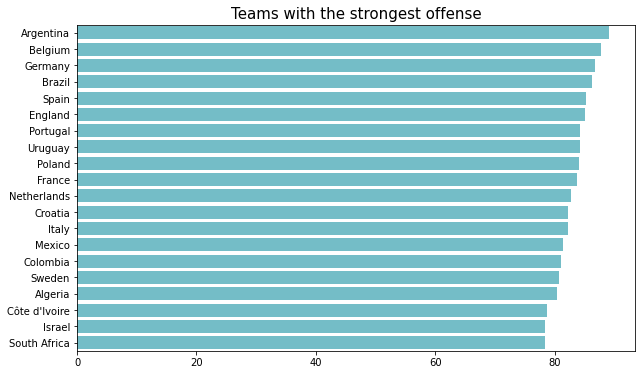

In [16]:
#plot the teams with the strongest offense players
fig, axes = plt.subplots(1,1,  figsize=(10, 6))
ax = sns.barplot(data = offense_top, y = 'team', x = 'offense_score', orientation = 'horizontal', color = "#66C8D5")
ax.set_title ('Teams with the strongest offense', fontsize = 15)
ax.set(xlabel = '', ylabel = '')

plt.show()

## Test-Train Splitting

##Feature engineering

## Establishing the training pipeline

## Model fitting and evaluation